# Compressed Sensing with gPIE

This notebook demonstrates compressed sensing reconstruction using Expectation Propagation (EP) in the Fourier domain. The reconstruction is performed under a sparsity prior using the gPIE framework.


### 1. Imports and Setup

In [23]:
import numpy as np
import matplotlib.pyplot as plt

from gpie import Graph, SparsePrior, GaussianMeasurement, fft2, mse
from gpie.core.linalg_utils import random_binary_mask
from gpie.examples.io_utils import load_sample_image

### 2. Problem Formulation

We assume a standard compressed sensing setup, where a sparse signal is transformed via FFT  
and then subsampled using a binary measurement mask:

$$
\mathbf{y} = M \cdot \mathcal{F}(\mathbf{x}) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2)
$$

Where:

- $ \mathbf{x} $: real-valued sparse image (latent variable)
- $ \mathcal{F} $: 2D centered FFT
- $ M $: binary mask selecting observed Fourier coefficients
- $ \varepsilon $: i.i.d. Gaussian noise

We define a sparsity-inducing prior $ \mathcal{P}_{\text{sparse}}(\mathbf{x}) $ and perform inference via:

$$
p(\mathbf{x} \mid \mathbf{y}) \propto p(\mathbf{y} \mid \mathbf{x}) \cdot \mathcal{P}_{\text{sparse}}(\mathbf{x})
$$

### 3. Sparsify Image

In [24]:
def sparsify_image(img: np.ndarray, rho: float) -> np.ndarray:
    flat = img.flatten()
    k = max(1, int(rho * flat.size))
    threshold = np.partition(np.abs(flat), -k)[-k]
    return np.where(np.abs(img) >= threshold, img, 0.0)

# Parameters
size = 256
rho = 0.1
subsample_rate = 0.3
noise_var = 1e-4
rng = np.random.default_rng(42)

# Load and sparsify image
img = load_sample_image("moon", shape=(size, size))
sparse_img = sparsify_image(img, rho).astype(np.complex64)

### 4. Build Factor Graph

In [25]:
# Create binary mask
mask = random_binary_mask((size, size), subsampling_rate=subsample_rate, rng=rng)

class CompressedSensingGraph(Graph):
    def __init__(self, rho, size):
        super().__init__()
        x = ~SparsePrior(rho=rho, shape=(size, size), damping=0.03, label="x", dtype=np.complex64)
        with self.observe():
            GaussianMeasurement(var=noise_var, mask=mask) @ fft2(x)
        self.compile()

graph = CompressedSensingGraph(rho = rho, size = size)
graph.set_init_rng(np.random.default_rng(seed=1))
graph.get_wave("x").set_sample(sparse_img)
graph.generate_sample(rng=np.random.default_rng(seed=9), update_observed=True)

- A real-valued latent variable $ \mathbf{x} $ is modeled with a `SparsePrior`
- Forward model:
  
  $$
  \mathbf{x} \rightarrow \mathcal{F} \rightarrow M \rightarrow \mathcal{N}(\cdot, \sigma^2)
  $$

- `GaussianMeasurement(...)` models subsampled noisy Fourier observations
- `get_wave("x").set_sample(...)` injects the sparsified image as ground truth
- `generate_sample(...)` simulates noisy measurement $ \mathbf{y} $

### 6. Run Inference

In [26]:
n_iter = 20
mse_list = []

true_x = graph.get_wave("x").get_sample()

def monitor(graph, t):
    if t % 5 == 0 or t == n_iter - 1:
        est = graph.get_wave("x").compute_belief().data
        err = mse(est, true_x)
        mse_list.append(err)
        print(f"[t={t}] MSE = {err:.5e}")

graph.run(n_iter=n_iter, callback=monitor)

[t=0] MSE = 3.74899e-01
[t=5] MSE = 1.06911e-03
[t=10] MSE = 4.91160e-05
[t=15] MSE = 4.73253e-05
[t=19] MSE = 4.73204e-05


### 7. Visualize Reconstruction

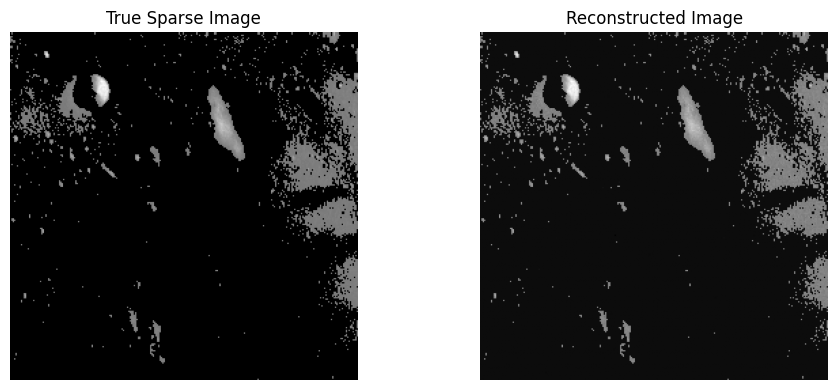

In [27]:
est_x = graph.get_wave("x").compute_belief().data
est_img = est_x.real.reshape((size, size))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(sparse_img.real.reshape((size, size)), cmap="gray")
axes[0].set_title("True Sparse Image")
axes[0].axis("off")

axes[1].imshow(est_img, cmap="gray")
axes[1].set_title("Reconstructed Image")
axes[1].axis("off")

plt.tight_layout()
plt.show()
